<a href="https://colab.research.google.com/github/xslittlemaggie/Tencent_Education_Deep_Learning_Course/blob/master/Airline_passengers_prediction_Time_Series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import time
import os
# visualization
import matplotlib.pyplot as plt

# model building
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import adam
from keras.layers import LSTM, SimpleRNN

from keras.callbacks import ModelCheckpoint
from keras.models import save_model, load_model


Using TensorFlow backend.


# 0. 简单RNN 结构 解析

In [2]:
N = 2 # 输入的x的维度， 也叫特征个数， 2 个特征 就是2， 例如，年龄， 教育
M = 3 # output dimension of each y_i

model = Sequential()
model.add(SimpleRNN(M,input_shape = (None, N),return_sequences = True))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 3)           18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [3]:
X = np.array([[1,2],[3,4],[5,6]])
model.predict(np.array([X])) # 两个样本[X, X]

array([[[-0.8874809 ,  0.9322754 , -0.89419174],
        [-0.77714384,  0.9998866 , -0.9962223 ],
        [-0.9720498 ,  0.9999995 , -0.9999109 ]]], dtype=float32)

In [4]:
X.shape # 步长 = 3, 表示用一个人前面的三次的值最为预测， 特征个数是2,例如 [1,2] 表示 年龄 = 1， 教育 = 2，

(3, 2)

In [0]:
W = model.get_weights()[0]
U = model.get_weights()[1]
b = model.get_weights()[2]

In [6]:
def myRNN(X_ls,W,U,b):
  
  Y_ls = []
  
  # initial state is zero
  h = np.zeros(M)
  
  for X in X_ls:
    Y = np.tanh(h.dot(U) + X.dot(W) + b)
    h = Y # state is simply the output
    Y_ls.append(Y)
  return Y_ls  
  
myRNN(X,W,U,b)

[array([-0.88748094,  0.93227543, -0.89419177]),
 array([-0.77714377,  0.99988656, -0.9962223 ]),
 array([-0.97204979,  0.99999955, -0.99991088])]

# 1. 数据导入， 输入处理

## 读取数据

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [8]:
data.head(10)

,Passengers
0,112
1,118
2,132
3,129
4,121
5,135
6,148
7,148
8,136
9,119


In [9]:
data.shape

(141, 1)

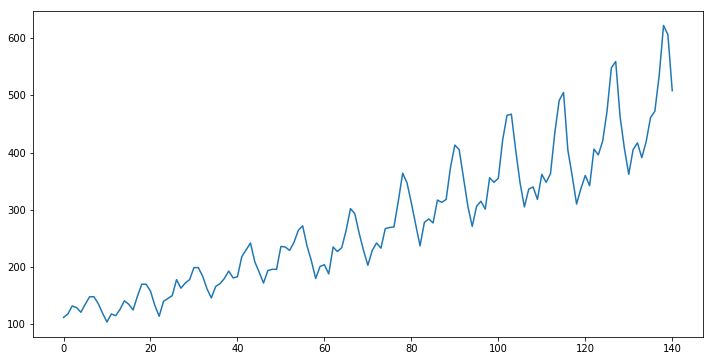

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(data["Passengers"])
plt.show()

## 数据预处理
- 归一化
- 标准化

我们用前面1-t时刻的数据，预测第 t + 1 时刻会有多少辆车

In [11]:
# 方法一：通过sklearn

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(data)
data = pd.DataFrame(data)

data.columns = ["Passengers"]
data.head()

,Passengers
0,0.015444
1,0.027027
2,0.054054
3,0.048263
4,0.032819


## 还原数据
最后通过一些列的输入之后，我们希望将预测的数据还原成原来数据的范围

例子：

In [12]:
"""
origin_data =scaler.inverse_transform([-1.390625, -1.340106])
origin_data
"""

'\norigin_data =scaler.inverse_transform([-1.390625, -1.340106])\norigin_data\n'

## 确定步长
例如步长 = 10
用前面的9个数预测第十个数

In [0]:
sequence_length = 2

result = []
for index in range(len(data) - sequence_length):
  result.append(data["Passengers"][index: index + sequence_length])
result = np.array(result).astype("float64")

In [14]:
result.shape

(139, 2)

## 训练集, 测试集划分

我们选了30%的数据作为测试，70%的数据进行训练。每个n长度的序列的最后一个值作为目标值，其余前面的部分作为输入值。输入值输入到模型，目标值是真实值，也就是模型想要达到的目标。

In [0]:
row = int(round(0.70 * result.shape[0]))   #70% 作为训练数据， 30% 作为测试数据
train = result[:row, :]
np.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = result[row:, :-1]
y_test = result[row:, -1]

### 输入数据：
输入必须是三维的

- 样本个数
- 时间步长
- 特征个数


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # 输入必须是三维的， 样本个数， 时间步长， 特征个数
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [17]:
print("X_train: ", X_train.shape)
print("Y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", y_test.shape)

X_train:  (97, 1, 1)
Y_train:  (97,)
X_test:  (42, 1, 1)
Y_test:  (42,)


# 2. 模型建立，训练

## 建立简单SimpleRNN模型

In [18]:
model = Sequential()

# 第一层
model.add(SimpleRNN(50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度，只有一个特征， 所以为1
                    return_sequences = False))   # 最后一层用False
  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))

model.compile(loss = "mse", optimizer = "rmsprop") # 回归问题用 mse

filepath = "weights-best-0.hdf5" #"weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',mode='min' ,save_best_only='True')

callback_lists=[checkpoint]

#checkpoint = ModelCheckpoint(filepath= "/content/", #(存放最好模型的地方)
#                            monitor="mse", # (想监视的值,比如acc,loss,
#                            
#                            # verbose=1(如果喜欢进度条,选1,如果喜欢清爽的就选0,verbose=冗余的),
#                            save_best_only="True", # (只保存最好的模型,也可以都保存),
#                            mode="auto") #(如果监视器monitor选val_acc, mode就选'max',如果monitor选acc,mode也可以选'max',如果monitor选loss,mode就选'min'),一般情况下选'auto',
#                            #period=1(checkpoints之间间隔的epoch数))



model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


### 第一组权重

In [19]:
# x * W
model.get_weights()[0].shape

(1, 50)

### 第二组权重

In [20]:
# s * U 
model.get_weights()[1].shape

(50, 50)

### 第三组权重

In [21]:
# bias
model.get_weights()[2].shape

(50,)

### 第四组权重

In [22]:
model.get_weights()[3].shape

(50, 1)

### 第五组权重

In [23]:
model.get_weights()[4]

array([0.], dtype=float32)

### 模型训练

In [24]:
epochs =300
history_0 = model.fit(X_train, y_train,
         batch_size = 1, 
         epochs = epochs, 
         validation_data = (X_test, y_test),
         callbacks=callback_lists)

Train on 97 samples, validate on 42 samples
Epoch 1/300
97/97 [==============================] - 1s 8ms/step - loss: 0.0237 - val_loss: 0.0643
Epoch 2/300
97/97 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0476
Epoch 3/300
97/97 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0188
Epoch 4/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0078
Epoch 5/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0107
Epoch 6/300
97/97 [==============================] - 1s 5ms/step - loss: 0.0041 - val_loss: 0.0087
Epoch 7/300
97/97 [==============================] - 1s 5ms/step - loss: 0.0032 - val_loss: 0.0093
Epoch 8/300
97/97 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 9/300
97/97 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0107
Epoch 10/300
97/97 [==============================] - 1s 6ms/step

In [25]:
print(min(history_0.history["loss"]))
print(min(history_0.history["val_loss"]))

0.0019325703252863872
0.007719734058225315


### 模型评估

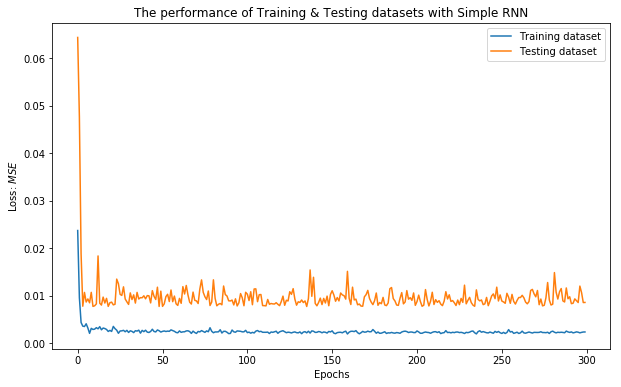

In [26]:
plt.figure(figsize = (10, 6))
plt.plot(history_0.history["loss"])
plt.plot(history_0.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
#plt.xticks(range(0, epochs + 1, 5))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets with Simple RNN")
plt.show()

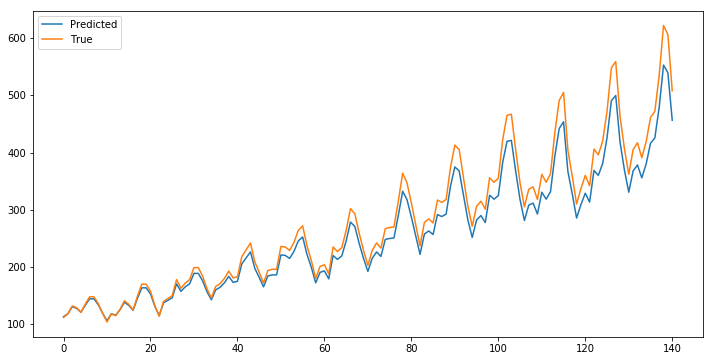

In [66]:
model = load_model('weights-best-0.hdf5')
sequence_length = 1
auto_predict_0 = []
for i in range(len(data)-sequence_length + 1):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict_0.append(res[0])

auto_predict_0 = scaler.inverse_transform(auto_predict_0)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict_0)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.show()


### 练习

In [28]:
x = np.array([[1],[3],[5]])

model = load_model('weights-best-0.hdf5')
sequence_length = 3
auto_predict_0 = []
for i in range(len(x)-sequence_length + 1):
  temp = x[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict_0.append(res[0])
auto_predict_0

[array([3.1595292], dtype=float32)]

## 单层LSTM

In [29]:
model = Sequential()

# 第一层
model.add(LSTM(50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度， 所以为1
                    return_sequences = False))   # 最后一层用False
  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = "rmsprop") # 线性回归问题用 rmsprop
filepath = "weights-best-1.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='loss',mode='min' ,save_best_only='True')

callback_lists=[checkpoint]
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [30]:
history_1 = model.fit(X_train, y_train,
         batch_size = 1, 
         epochs = epochs, 
         validation_data = (X_test, y_test),  # validation_split = 0.05, 
         callbacks=callback_lists)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 97 samples, validate on 42 samples
Epoch 1/300
97/97 [==============================] - 1s 15ms/step - loss: 0.0243 - val_loss: 0.1324
Epoch 2/300
97/97 [==============================] - 1s 7ms/step - loss: 0.0126 - val_loss: 0.0795
Epoch 3/300
97/97 [==============================] - 1s 7ms/step - loss: 0.0104 - val_loss: 0.0717
Epoch 4/300
97/97 [==============================] - 1s 7ms/step - loss: 0.0091 - val_loss: 0.0564
Epoch 5/300
97/97 [==============================] - 1s 7ms/step - loss: 0.0065 - val_loss: 0.0420
Epoch 6/300
97/97 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0318
Epoch 7/300
97/97 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0153
Epoch 8/300
97/97 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0128
Epoch 9/300
97/97 [==============================] - 1s 7ms/step - lo

In [31]:
print(min(history_1.history["loss"]))
print(min(history_1.history["val_loss"]))

0.0018420665923371154
0.007725402924460836


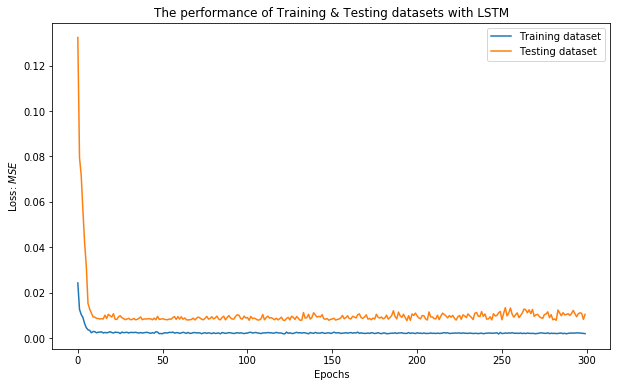

In [32]:
plt.figure(figsize = (10, 6))
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets with LSTM")
plt.show()

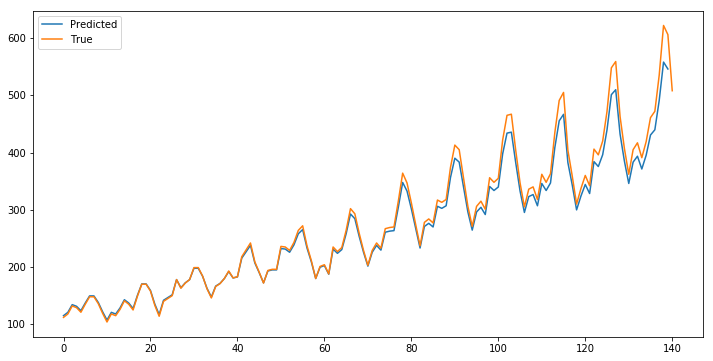

In [33]:
model = load_model('weights-best-1.hdf5')
sequence_length = 1
auto_predict_1 = [] #np.array([[np.nan]])
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict_1.append(res[0])

auto_predict_1 = scaler.inverse_transform(auto_predict_1)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict_1)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.show()

## 调参 1. 数据标准化（如上）

## 调参 2. 改变序列长度

In [0]:
sequence_length = 4

result_1 = []
for index in range(len(data) - sequence_length):
  result_1.append(data["Passengers"][index: index + sequence_length])
result_1 = np.array(result_1).astype("float64")

row = int(round(0.67 * result_1.shape[0]))   #90% 作为训练数据， 10% 作为测试数据
train_1 = result_1[:row, :]
np.random.shuffle(train_1)
X_train_1 = train_1[:, :-1]
y_train_1 = train_1[:, -1]
X_test_1 = result_1[row:, :-1]
y_test_1 = result_1[row:, -1]

X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], 1))  # 输入必须是三维的， 样本个数， 时间步长， 特征个数
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], 1))

In [35]:
print("X_train: ", X_train_1.shape)
print("Y_train: ", y_train_1.shape)
print("X_test: ", X_test_1.shape)
print("Y_test: ", y_test_1.shape)

X_train:  (92, 3, 1)
Y_train:  (92,)
X_test:  (45, 3, 1)
Y_test:  (45,)


In [36]:
model = Sequential()

# 第一层
model.add(LSTM(50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度， 所以为1
                    return_sequences = False   # 最后一层用False
))  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = "rmsprop") # 线性回归问题用 rmsprop

filepath = "weights-best-2.hdf5" #"weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',mode='min' ,save_best_only='True')

callback_lists=[checkpoint]

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_2 = model.fit(X_train_1, y_train_1,
         batch_size = 1, 
         epochs = 300, 
         validation_data = (X_test_1, y_test_1), 
         callbacks=callback_lists)

Train on 92 samples, validate on 45 samples
Epoch 1/300
92/92 [==============================] - 2s 21ms/step - loss: 0.0153 - val_loss: 0.0435
Epoch 2/300
92/92 [==============================] - 1s 12ms/step - loss: 0.0073 - val_loss: 0.0383
Epoch 3/300
92/92 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0353
Epoch 4/300
92/92 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0180
Epoch 5/300
92/92 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0175
Epoch 6/300
92/92 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 0.0171
Epoch 7/300
92/92 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0249
Epoch 8/300
92/92 [==============================] - 1s 11ms/step - loss: 0.0059 - val_loss: 0.0226
Epoch 9/300
92/92 [==============================] - 1s 12ms/step - loss: 0.0050 - val_loss: 0.0193
Epoch 10/300
92/92 [==============================] - 1s

In [38]:
print(min(history_2.history["loss"]))
print(min(history_2.history["val_loss"]))

0.0015653163273690813
0.006012034525130932


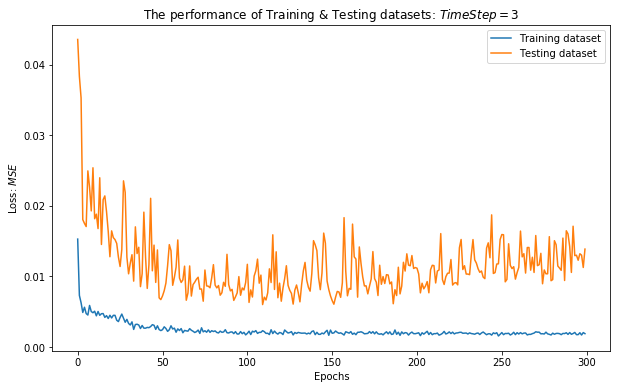

In [39]:
plt.figure(figsize = (10, 6))
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
#plt.xticks(range(0, 200 + 1, 5))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets: $TimeStep = 3$")
plt.show()

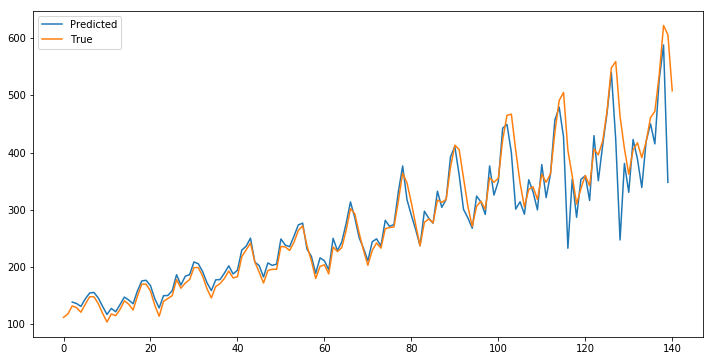

In [40]:
model = load_model('weights-best-2.hdf5')
sequence_length = 3
auto_predict_2 = [np.array([[np.nan]]), np.array([[np.nan]])]
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict_2.append(res[0])

auto_predict_2 = scaler.inverse_transform(auto_predict_2)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict_2)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.show()

## 调参 3. 加大模型深度

In [41]:
model = Sequential()

# 第一层
model.add(LSTM(
        50, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(100,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))

start = time.time()
model.compile(loss = "mse", optimizer = adam())  # rmsprop 线性回归问题的标准做法， ADAM（）

filepath = "weights-best-3.hdf5" #"weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',mode='min' ,save_best_only='True')

callback_lists=[checkpoint]
print("Compilation Time:", time.time() - start)

Compilation Time: 0.03037095069885254


In [42]:
epochs = 300
history_3 = model.fit(X_train_1, y_train_1,
         batch_size = 1, 
         epochs = epochs, 
         validation_data = (X_test_1, y_test_1),
         callbacks=callback_lists)

Train on 92 samples, validate on 45 samples
Epoch 1/300
92/92 [==============================] - 4s 40ms/step - loss: 0.0128 - val_loss: 0.0246
Epoch 2/300
92/92 [==============================] - 2s 19ms/step - loss: 0.0079 - val_loss: 0.0232
Epoch 3/300
92/92 [==============================] - 2s 17ms/step - loss: 0.0066 - val_loss: 0.0205
Epoch 4/300
92/92 [==============================] - 2s 18ms/step - loss: 0.0058 - val_loss: 0.0334
Epoch 5/300
92/92 [==============================] - 2s 17ms/step - loss: 0.0060 - val_loss: 0.0219
Epoch 6/300
92/92 [==============================] - 2s 17ms/step - loss: 0.0050 - val_loss: 0.0189
Epoch 7/300
92/92 [==============================] - 2s 21ms/step - loss: 0.0062 - val_loss: 0.0288
Epoch 8/300
92/92 [==============================] - 2s 18ms/step - loss: 0.0054 - val_loss: 0.0206
Epoch 9/300
92/92 [==============================] - 2s 21ms/step - loss: 0.0056 - val_loss: 0.0297
Epoch 10/300
92/92 [==============================] - 2s

In [43]:
print(min(history_3.history["loss"]))
print(min(history_3.history["val_loss"]))

0.001482087083534222
0.005581793032474201


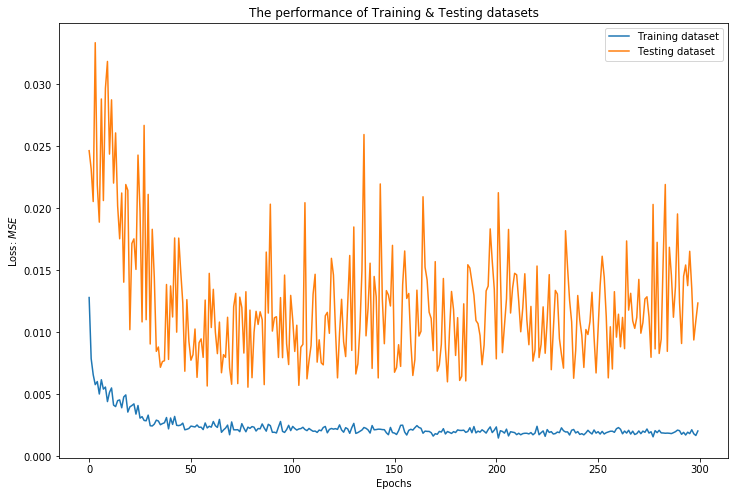

In [44]:
plt.figure(figsize = (12, 8))
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
#plt.xticks(range(0, epochs, 2))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets")
plt.show()

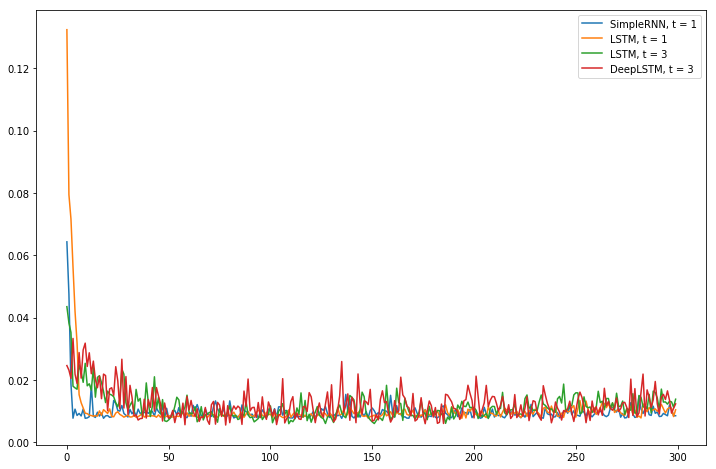

In [45]:
plt.figure(figsize = (12, 8))
plt.plot(history_0.history["val_loss"])
plt.plot(history_1.history["val_loss"])
plt.plot(history_2.history["val_loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["SimpleRNN, t = 1", "LSTM, t = 1", "LSTM, t = 3", "DeepLSTM, t = 3"])
plt.show()

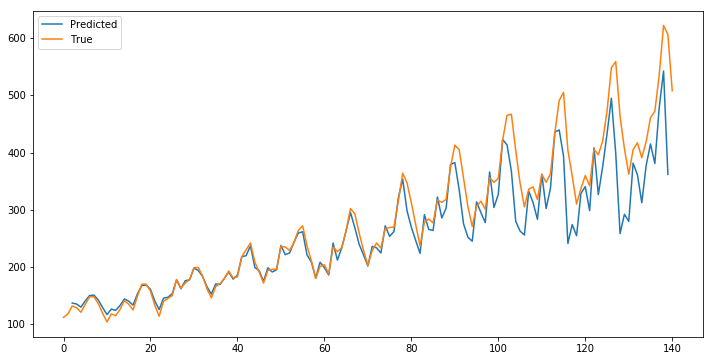

In [46]:
model = load_model('weights-best-3.hdf5')
sequence_length = 3
auto_predict_3 = [np.array([[np.nan]]), np.array([[np.nan]])] 
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict_3.append(res[0])

auto_predict_3 = scaler.inverse_transform(auto_predict_3)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict_3)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.show()

## 增加输出个数（神经元个数）

In [0]:
model = Sequential()

# 第一层
model.add(LSTM(
        100, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(200,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))

model.compile(loss = "mse", optimizer = adam())  # rmsprop 线性回归问题的标准做法， ADAM（）

filepath = "weights-best-4.hdf5" #"weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',mode='min' ,save_best_only='True')

callback_lists=[checkpoint]

In [48]:
epochs = 300
history_4 = model.fit(X_train_1, y_train_1,
         batch_size = 1, 
         epochs = epochs, 
         validation_data = (X_test_1, y_test_1),
         callbacks=callback_lists)

Train on 92 samples, validate on 45 samples
Epoch 1/300
92/92 [==============================] - 4s 48ms/step - loss: 0.0114 - val_loss: 0.0774
Epoch 2/300
92/92 [==============================] - 2s 19ms/step - loss: 0.0079 - val_loss: 0.0335
Epoch 3/300
92/92 [==============================] - 2s 19ms/step - loss: 0.0059 - val_loss: 0.0177
Epoch 4/300
92/92 [==============================] - 2s 18ms/step - loss: 0.0069 - val_loss: 0.0171
Epoch 5/300
92/92 [==============================] - 2s 19ms/step - loss: 0.0048 - val_loss: 0.0235
Epoch 6/300
92/92 [==============================] - 2s 20ms/step - loss: 0.0053 - val_loss: 0.0247
Epoch 7/300
92/92 [==============================] - 2s 19ms/step - loss: 0.0050 - val_loss: 0.0228
Epoch 8/300
92/92 [==============================] - 2s 18ms/step - loss: 0.0056 - val_loss: 0.0288
Epoch 9/300
92/92 [==============================] - 2s 20ms/step - loss: 0.0044 - val_loss: 0.0138
Epoch 10/300
92/92 [==============================] - 2s

In [49]:
print(min(history_4.history["loss"]))
print(min(history_4.history["val_loss"]))

0.0015327660067525715
0.0056704681293770895


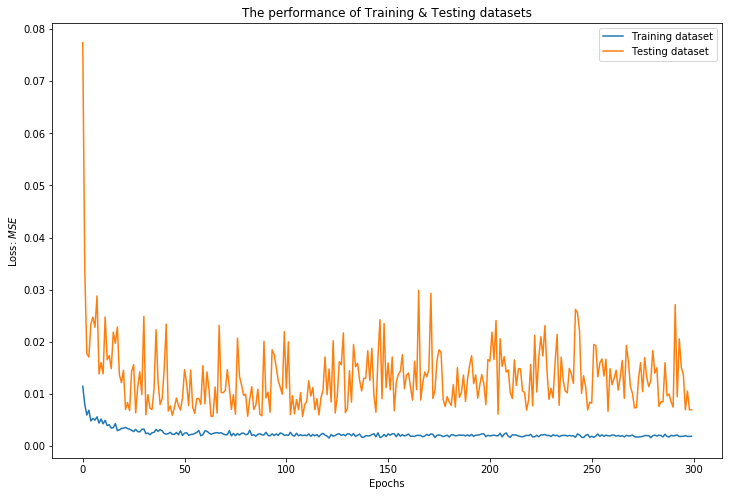

In [50]:
plt.figure(figsize = (12, 8))
plt.plot(history_4.history["loss"])
plt.plot(history_4.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
#plt.xticks(range(0, epochs, 2))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets")
plt.show()

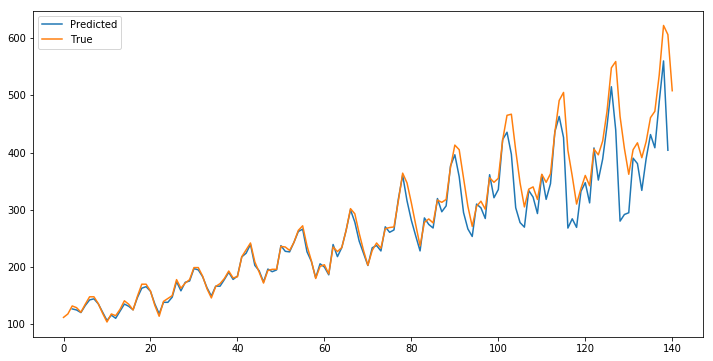

In [65]:
model = load_model('weights-best-4.hdf5')
sequence_length = 3
auto_predict_4 = [np.array([[np.nan]]), np.array([[np.nan]])]
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict_4.append(res[0])

auto_predict_4 = scaler.inverse_transform(auto_predict_4)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict_4)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.show()

## 模型的不同性能评估

In [52]:
model = Sequential()

# 第一层
model.add(LSTM(
        50, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(100,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer ="rmsprop", metrics=['mse', 'mae', 'mape', 'cosine']) 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
__________________________________________________

In [53]:
epochs = 300
history_5 = model.fit(X_train_1, y_train_1,
         batch_size = 1, 
         epochs = epochs, 
         validation_split = 0.05)
model.save('model_5.h5')  # creates a HDF5 file 'my_model.h5'

Train on 87 samples, validate on 5 samples
Epoch 1/300
87/87 [==============================] - 5s 55ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0890 - mean_absolute_percentage_error: 1576616.7969 - cosine_proximity: -0.9655 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0898 - val_mean_absolute_percentage_error: 99.6614 - val_cosine_proximity: -1.0000
Epoch 2/300
87/87 [==============================] - 2s 19ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0661 - mean_absolute_percentage_error: 1952462.1384 - cosine_proximity: -0.9885 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0826 - val_mean_absolute_percentage_error: 78.6452 - val_cosine_proximity: -1.0000
Epoch 3/300
87/87 [==============================] - 2s 18ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0603 - mean_absolute_percentage_error: 1163580.7731 - cosine_pro

In [54]:
min(history_5.history["val_loss"])

0.002394853189252899

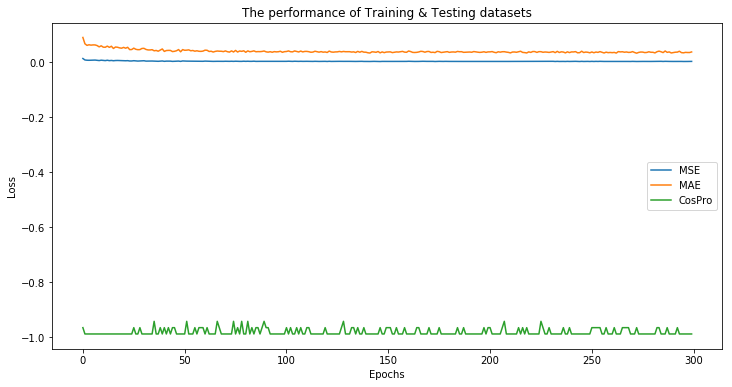

In [56]:
# plot metrics
plt.figure(figsize = (12, 6))
plt.plot(history_5.history['mean_squared_error'])
plt.plot(history_5.history['mean_absolute_error'])
plt.plot(history_5.history['cosine_proximity'])
plt.legend(["MSE", "MAE", "CosPro"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The performance of Training & Testing datasets")
plt.show()

## self prediction

In [0]:
model = load_model('weights-best-3.hdf5')

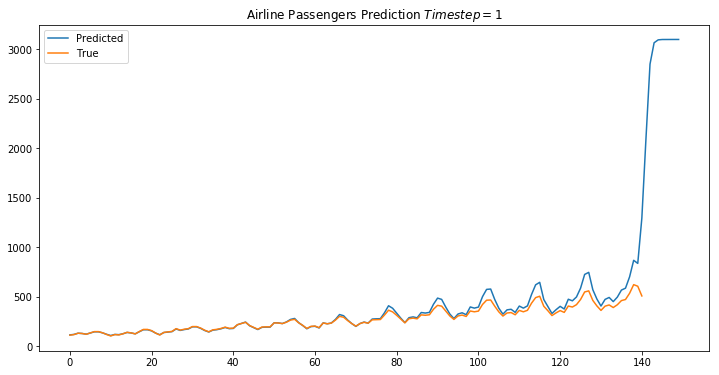

In [58]:
sequence_length = 1
auto_predict = [] 
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

for i in range(10):
  temp = auto_predict[-1 * sequence_length:]
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])
  
auto_predict = scaler.inverse_transform(auto_predict)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.title("Airline Passengers Prediction $Timestep = 1$")

plt.show()  

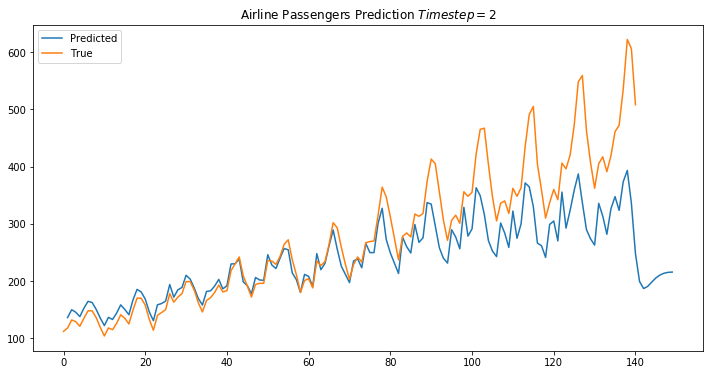

In [59]:
sequence_length = 2
auto_predict = [np.array([[np.nan]])] 
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

for i in range(10):
  temp = auto_predict[-1 * sequence_length:]
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])
  
auto_predict = scaler.inverse_transform(auto_predict)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.title("Airline Passengers Prediction $Timestep = 2$")

plt.show()  

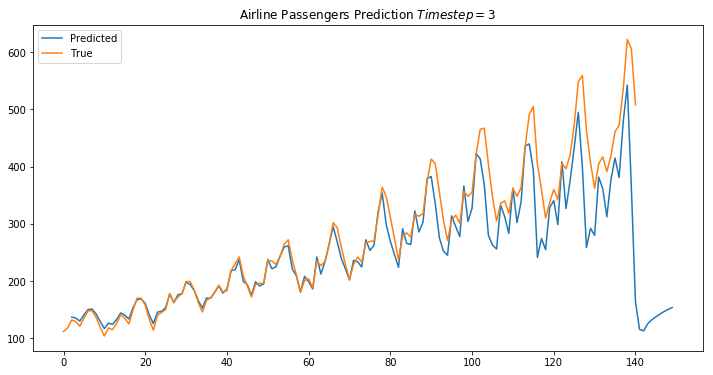

In [60]:
sequence_length = 3
auto_predict = [np.array([[np.nan]]), np.array([[np.nan]])] 
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

for i in range(10):
  temp = auto_predict[-1 * sequence_length:]
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])
  
auto_predict = scaler.inverse_transform(auto_predict)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.title("Airline Passengers Prediction $Timestep = 3$")

plt.show()  

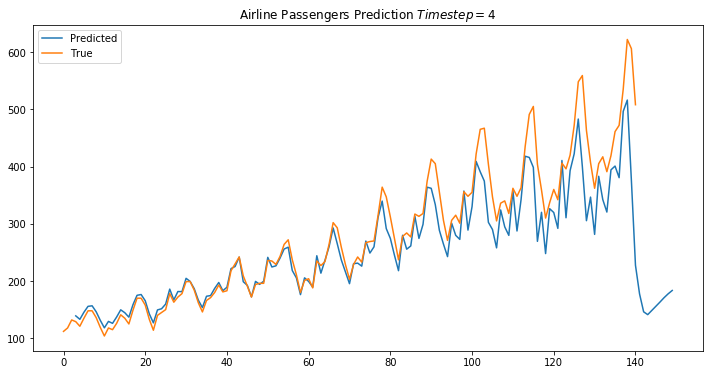

In [61]:
sequence_length = 4
auto_predict = [np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]])] 
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

for i in range(10):
  temp = auto_predict[-1 * sequence_length:]
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

auto_predict = scaler.inverse_transform(auto_predict)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.title("Airline Passengers Prediction $Timestep = 4$")
plt.show()  

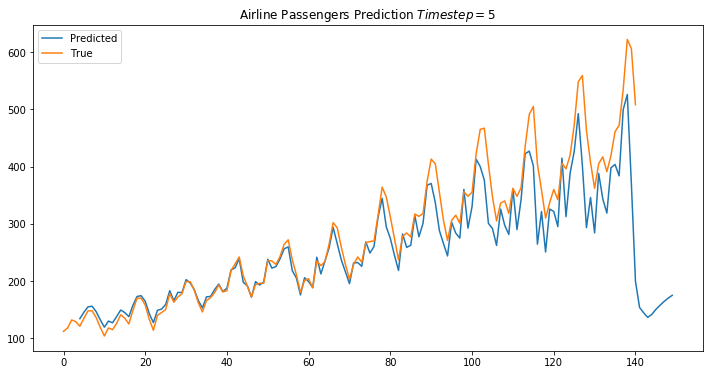

In [62]:
sequence_length = 5
auto_predict = [np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]])] 
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

for i in range(10):
  temp = auto_predict[-1 * sequence_length:]
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

auto_predict = scaler.inverse_transform(auto_predict)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.title("Airline Passengers Prediction $Timestep = 5$")
plt.show() 

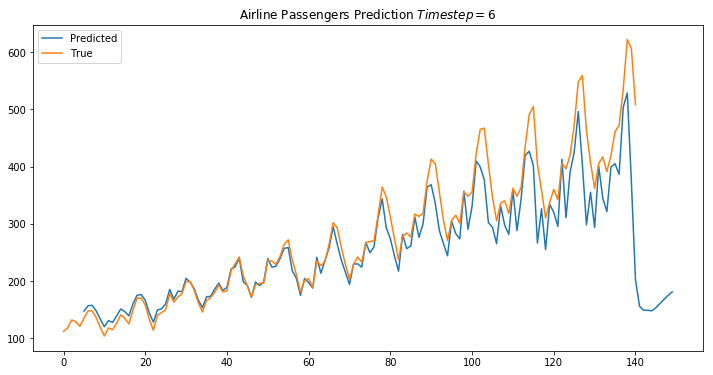

In [63]:
sequence_length = 6
auto_predict = [np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]])] 
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

for i in range(10):
  temp = auto_predict[-1 * sequence_length:]
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

auto_predict = scaler.inverse_transform(auto_predict)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.title("Airline Passengers Prediction $Timestep = 6$")
plt.show() 

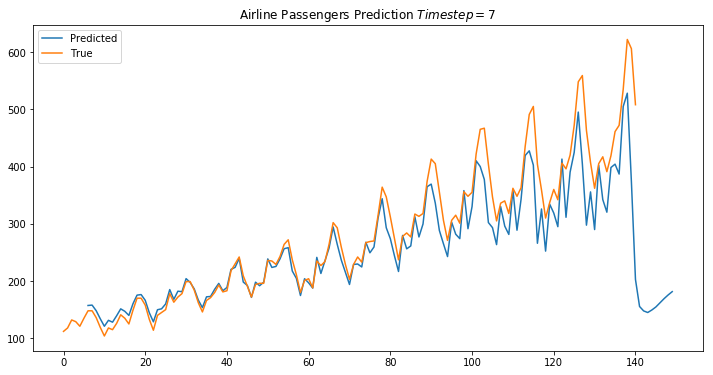

In [64]:
sequence_length = 7
auto_predict = [np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]]), np.array([[np.nan]])]  
for i in range(len(data)-sequence_length):
  temp = data.values[i: i + sequence_length]
  #print(temp)
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

for i in range(10):
  temp = auto_predict[-1 * sequence_length:]
  temp = np.reshape(temp, (1, sequence_length, 1))
  res = model.predict(temp)
  auto_predict.append(res[0])

auto_predict = scaler.inverse_transform(auto_predict)
plt.figure(figsize = (12, 6))
plt.plot(auto_predict)
plt.plot(scaler.inverse_transform(data))
plt.legend(["Predicted", "True"])
plt.title("Airline Passengers Prediction $Timestep = 7$")
plt.show() 